In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio
from shapely.geometry import Point, LineString, Polygon, MultiPoint, box
import fiona
from shapely.ops import nearest_points
import pickle

In [2]:
xmin, xmax, ymin, ymax = -382700, -374781.9, -734075.1, -721770.2

In [3]:
!pwd

/Users/home/whitefar/DATA/Jupyter/PLOTS/data_paper


In [4]:
# x_interpd = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_x.npy')
# y_interpd = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_y.npy')
# it_interpd = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_ice_thickn.npy')
# ib_interpd = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_icebase.npy')

In [5]:
#load REMA
nid1 = 159202
nid2 = 131226
df = gpd.read_file('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/REMA_Strip_Index_Rel1/REMA_Strip_Index_Rel1.shp')

In [6]:
path = f"/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_159202-131226_diff.tif"
f = df.loc[nid1].acquisitio
t =df.loc[nid2].acquisitio

In [7]:
df.loc[nid2].fileurl

'http://data.pgc.umn.edu/elev/dem/setsm/REMA/geocell/v1.0/2m/s83w153/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0.tar.gz'

In [8]:
duration = (pd.to_datetime(t)-pd.to_datetime(f)).days/365.25
with rio.open(path) as image:
    im = image.read(1)
    im = im / duration
#     im[im==-9999] = np.nan
    extent_REMAdiff = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    left = image.bounds[0]
    bottom = image.bounds[1]
    right = image.bounds[2]    
    top = image.bounds[3]
    

In [9]:
#load REMA demfocussing on
with rio.open('/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif') as image:
    extent_REMA = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_REMA = image.read(1)
    
x = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')
y = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')

# xv_o, yv_o = np.meshgrid(x_c, y_c)


x_i = np.argwhere((x>xmin) & (x< xmax)).flatten()[0]
x_j = np.argwhere((x>xmin) & (x< xmax)).flatten()[-1]
y_i = np.argwhere((y>ymin) & (y< ymax)).flatten()[0]
y_j = np.argwhere((y>ymin) & (y< ymax)).flatten()[-1]

x_c = np.linspace(extent_REMA[0],extent_REMA[1],im_REMA.shape[1]).astype('int')[x_i:x_j]
y_c = np.linspace(extent_REMA[3],extent_REMA[2],im_REMA.shape[0]).astype('int')[y_i:y_j]

xv_REMA, yv_REMA = np.meshgrid(x_c, y_c)

im_REMA_d = im_REMA[y_i:y_j,x_i:x_j]
im_REMA_d[im_REMA_d==-99.99] = np.nan
im_REMA_c = im_REMA_d

In [10]:
im_REMA[im_REMA!=-9999.0].mean()

67.36358

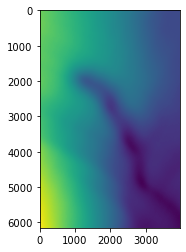

In [11]:
plt.imshow(im_REMA_c)

In [12]:
# im_REMAdiff[np.abs(im_REMAdiff)>50]=np.nan

In [13]:
# # Load ice base interpolated from radar results
# direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/highres_gridded_'

# xv = np.load(direc + 'x_grid' +'.npy')
# yv = np.load(direc + 'y_grid' +'.npy')
# thickness_interpolated = np.load(direc +'ice_thickn.npy')
# extent_l2l = np.load(direc +'extent.npy')
# ice_base = np.load(direc +'ice_base.npy')
# ice_base_smooth = sp.ndimage.gaussian_filter(ice_base, sigma=30, order=0)

In [14]:
with open('/Users/home/whitefar/DATA/global_corrections.pkl',"rb") as f2:
    correct = pickle.load(f2)
geoid_correction = correct['geoid_correction']
res_correction = correct['res_correction']
apres_firn = correct['apres_firn']

In [15]:
# #smooth REMA dem for contours
# im_REMA_c_smoo = sp.ndimage.gaussian_filter(im_REMA_c, sigma=20, order=0)
# del im_REMA_d,im_REMA_c

In [16]:
# plt.figure(figsize=(15,15))
# GyRd = plt.cm.get_cmap('RdGy').reversed()
# plt.imshow(im,extent=extent_REMAdiff, vmin=-1,vmax=1,cmap=GyRd)
# cb = plt.colorbar()
# cb.set_label('rate of elevation change, m/a')
# plt.xlim([-382000, -374800])
# plt.ylim([-733300,-724000])
# plt.grid()
# plt.show()

In [17]:
# plt.figure(figsize=(15,15))
# GyRd = plt.cm.get_cmap('RdGy').reversed()
# plt.imshow(im,extent=extent_REMAdiff, vmin=-1,vmax=1,cmap=GyRd)
# cb = plt.colorbar()
# cb.set_label('rate of elevation change, m/a')
# plt.xlim([-382000, -379000])
# plt.ylim([-727000,-724000])
# plt.grid()
# plt.show()

# Variance over stable terrain

In [18]:
# grounded = np.load('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable.npy')
# xv = np.load('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_xv.npy')
# yv = np.load('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_yv.npy')
# grounded_nonan = np.load('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_nonan.npy')

In [19]:
#there are two clusters of grounded points, north and south of 726000
# grounded_points = np.array([xv[grounded==1].T,yv[grounded==1].T])

In [20]:
# grounded_points_N = grounded_points[:, grounded_points[1,:]>-725700]
# grounded_points_S = grounded_points[:, grounded_points[1,:]<-726500]

In [21]:
# plt.plot(grounded_points_N[0,:],grounded_points_N[1,:])
# plt.plot(grounded_points_S[0,:],grounded_points_S[1,:])

In [22]:
# N_hull = MultiPoint( [(x,y) for x,y in zip(grounded_points_N[0,::2],grounded_points_N[1,::2])]).convex_hull
# S_hull = MultiPoint( [(x,y) for x,y in zip(grounded_points_S[0,::2],grounded_points_S[1,::2])]).convex_hull

In [23]:
# S_hull

In [24]:
with open('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/shapefiles/bullseye.pkl', "rb") as poly_file:
    bullseye = pickle.load(poly_file)

In [28]:
# gdf_N = gpd.GeoDataFrame(geometry=[N_hull])
# gdf_S = gpd.GeoDataFrame(geometry=[S_hull])
gdf_bullseye = gpd.GeoDataFrame(geometry=[bullseye])
# gdf_N

In [29]:
# gdf_N.to_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_shapefile_N.shp')
# gdf_S.to_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_shapefile_S.shp')
# gdf_bullseye.to_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/bullseye.shp')

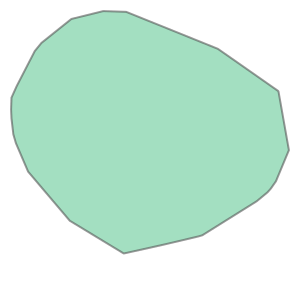

In [30]:
bullseye

QGIS DID 
```
gdalwarp -overwrite -s_srs EPSG:3031 -t_srs EPSG:3031 -of GTiff -tr 2.0 -2.0 -tap -cutline /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_shapefile.shp -cl stable_shapefile -crop_to_cutline /Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_159202-131226_diff.tif /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_stable.tif
```

```
gdalwarp -overwrite -s_srs EPSG:3031 -t_srs EPSG:3031 -of GTiff -cutline /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_shapefile_N.shp -cl stable_shapefile_N -crop_to_cutline /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_stable.tif /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_stable_N.tif
```

```
gdalwarp -overwrite -s_srs EPSG:3031 -t_srs EPSG:3031 -of GTiff -cutline /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/stable_shapefile_S.shp -cl stable_shapefile_S -crop_to_cutline /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_stable.tif /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_stable_S.tif
```

```
gdalwarp -overwrite -s_srs EPSG:3031 -t_srs EPSG:3031 -of GTiff -cutline /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/bullseye.shp -cl bullseye -crop_to_cutline /Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_159202-131226_diff.tif /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_bullseye.tif
```

In [31]:
stable_diff = {}
stable_diff_extent = {}
for tif in ['diff_masked_to_stable_N','diff_masked_to_stable_S','diff_masked_to_bullseye','diff_masked_to_handrawn']:

    with rio.open(f'/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/{tif}.tif') as image:
        stable_diff[tif] =   image.read(1)/ duration
        
        stable_diff_extent[tif] = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
#     with rio.open('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_stable_S.tif') as image:
#         stable_diff_S = image.read(1)
#         stable_diff_extent_S = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
#     with rio.open('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_stable_N.tif') as image:
#         stable_diff_N = image.read(1)
#         stable_diff_extent_N = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
#     with rio.open('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_bullseye.tif') as image:
#         stable_diff_bullseye = image.read(1)
#         stable_diff_extent_bullseye = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]

In [32]:
# stable_diff.keys()

In [33]:
# for k in stable_diff.keys():
#     stable_diff[k][stable_diff[k]<-2] = np.nan
#     stable_diff[k][stable_diff[k]>2] = np.nan
#     plt.figure()
#     plt.imshow(stable_diff[k],vmin=-1,vmax=1)
#     plt.colorbar()

In [34]:
stable_diff.keys()

dict_keys(['diff_masked_to_stable_N', 'diff_masked_to_stable_S', 'diff_masked_to_bullseye', 'diff_masked_to_handrawn'])

In [35]:
# n, bins, patches = plt.hist(im[im>-2], 
#                               bins=np.linspace(-2,2,100), 
#                               density=True,alpha=0.5,
# #                                 color=color[i],
# #                             label=labels[i]
#                            )

In [36]:
# plt.figure(figsize=(15,10))
# labels=stable_diff.keys()
# color=['blue','orange','green']
# for k in list(stable_diff.keys()):
#     n, bins, patches = plt.hist(stable_diff[k][::10][~np.isnan(stable_diff[k][::10])], 
#                                   bins=np.linspace(-2,2,100), 
#                                   density=True,alpha=0.5,
# #                                 color=color[i],
#                                 label=k
#                                )

# #     plt.vlines(np.mean(stable_diff[i]),0,1.7,color='black')
# #     plt.vlines(np.mean(stable_diff[i])-np.std(stable_diff[i]),0,1.7,color='red')
# #     plt.vlines(np.mean(stable_diff[i])+np.std(stable_diff[i]),0,1.7,color='red')

# # n, bins, patches = plt.hist(im[im>-10], 
# #                               bins=np.linspace(-5,5,100), 
# #                               density=True,alpha=0.5,
# # #                                 color=color[i],
# #                             label='Full difference image'
# #                            )
# plt.legend()
# plt.xlabel("Vertical diff, 'm'")
# plt.ylabel("Probablility density")
# plt.grid()

In [37]:
# n, bins, patches = plt.hist(stable_diff[k][::10], 
#                                   bins=np.linspace(-5,5,100), 
#                                   density=True,alpha=0.5,
# #                                 color=color[i],
#                                 label=k
#                                )

In [38]:
for a in stable_diff.keys():
    print(a)
    print(np.nanmean(stable_diff[a]),np.nanstd(stable_diff[a]))
    

diff_masked_to_stable_N
-1771.6058 1196.1458
diff_masked_to_stable_S
-2094.8938 1007.8493
diff_masked_to_bullseye
-780.56494 1185.2139
diff_masked_to_handrawn
-1618.0603 1268.9137


In [39]:
stable_diff['diff_masked_to_bullseye']

array([[-2579.1912, -2579.1912, -2579.1912, ..., -2579.1912, -2579.1912,
        -2579.1912],
       [-2579.1912, -2579.1912, -2579.1912, ..., -2579.1912, -2579.1912,
        -2579.1912],
       [-2579.1912, -2579.1912, -2579.1912, ..., -2579.1912, -2579.1912,
        -2579.1912],
       ...,
       [-2579.1912, -2579.1912, -2579.1912, ..., -2579.1912, -2579.1912,
        -2579.1912],
       [-2579.1912, -2579.1912, -2579.1912, ..., -2579.1912, -2579.1912,
        -2579.1912],
       [-2579.1912, -2579.1912, -2579.1912, ..., -2579.1912, -2579.1912,
        -2579.1912]], dtype=float32)

In [42]:
# N_hull.exterior.coords.xy[0]

In [43]:
extent_REMApic = extent_REMAdiff.copy()

In [44]:
yticks = (np.linspace(-734000,-722000,4)/1000).astype(int)
xticks = (np.linspace(-382000,-376000,4)/1000).astype(int)

In [45]:
# plt.figure( dpi=180,figsize=(6,8))

# plt.rcParams.update({'font.size': 11})


# # #C base with surface contours
# samp = 50
# CS =  plt.contour(xv_REMA[::samp]/1000,yv_REMA[::samp]/1000,im_REMA_c_smoo[::samp]+geoid_correction,
#                       30,vmin=15+geoid_correction,vmax=90+geoid_correction, 
# #                   cmap='BrBG',
#                   colors='black',
#                   alpha=0.5,linewidths=0.7)
# plt.clabel(CS,CS.levels[0::4], inline=1,  fmt='%i')

# for shape in [N_hull,S_hull,bullseye]:
#     plt.plot(np.array(shape.exterior.coords.xy[0])/1000,np.array(shape.exterior.coords.xy[1])/1000,linewidth=5)
    
# plt.imshow(ice_base+geoid_correction+res_correction,extent=np.array(extent_l2l)/1000,cmap='Blues_r',vmin=-700+geoid_correction+res_correction,vmax=-340+geoid_correction+res_correction)
# cb3 = plt.colorbar()
# cb3.set_label('Elevation of ice base, m')
# cb3.set_ticks(np.round(np.linspace(-350+geoid_correction + res_correction,-700+geoid_correction + res_correction,5)/5)*5)

# # plt.plot(gpr.x/1000,gpr.y/1000,'r.',label='radar profiles',markersize=0.05)

# plt.xlim([xmin/1000,xmax/1000])
# plt.ylim([ymin/1000,ymax/1000])
# plt.xticks(xticks)
# plt.yticks(yticks)
# plt.xlabel('Easting, polar stereographic, km')
# plt.ylabel('Northing, polar stereographic, km')
# plt.grid()


In [46]:
# plt.imshow(im, vmin=-1,vmax=1,cmap=GyRd)


In [47]:
# slope = np.sqrt(np.diff(im,axis=0)[:,1:]**2+np.diff(im,axis=1)[1:,:]**2)

In [48]:
# plt.figure(figsize=(15,15))
# plt.imshow(slope,extent=extent_REMAdiff,vmin=-0.01,vmax=0.01,cmap='inferno')
# plt.xlim([-393000,extent_REMAdiff[1]])
# plt.ylim([extent_REMAdiff[2],-707000])
# plt.show()

In [49]:
bbox = box(xmin, xmax, ymin, ymax )
#groundingline
groundingline_path = glob.glob(f"/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Miscellaneous/ScrippsGroundingLine/*.shp")[0]
groundingline =  gpd.read_file(groundingline_path)
# groundingline_path

groundingline = groundingline[groundingline.geometry.intersects(bbox)].copy()

coast = groundingline.geometry.iloc[0].exterior.coords[:]

gl = np.array([[x,y] for x,y in coast ])

gl = gl[(gl[:,0]< -360000) & (gl[:,0]> -400000) & (gl[:,1] > -760000) & (gl[:,1] <  -700000)].copy()
# gl = gl[(gl[:,0]< xmax) & (gl[:,0]> xmin) & (gl[:,1] > ymin) & (gl[:,1] <  ymax)].copy()

In [50]:
groundingline_path

'/Volumes/arc_02/REMOTE_SENSING/Quantarctica3/Miscellaneous/ScrippsGroundingLine/scripps_antarctica_polygons_v1.shp'

# full grounded area

```
gdalwarp -overwrite -s_srs EPSG:3031 -t_srs EPSG:3031 -of GTiff -cutline /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/handdrawn_stablemask_3031.shp -cl handdrawn_stablemask_3031 -crop_to_cutline /Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/DIFFERENCES/REMA_159202-131226_diff.tif /Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/diff_masked_to_handrawn.tif
```

In [51]:
# plt.figure(figsize=(15,10))
# labels=['Northern stable area','Southern stable area','Area of lowering','handdrawn']
# color=['blue','orange','green']
# for i in range(4):
#     n, bins, patches = plt.hist(stable_diff[i], 
#                                   bins=np.linspace(-5,5,100), 
#                                   density=True,alpha=0.5,
# #                                 color=color[i],
#                                 label=labels[i]
#                                )

# #     plt.vlines(np.mean(stable_diff[i]),0,1.7,color='black')
# #     plt.vlines(np.mean(stable_diff[i])-np.std(stable_diff[i]),0,1.7,color='red')
# #     plt.vlines(np.mean(stable_diff[i])+np.std(stable_diff[i]),0,1.7,color='red')
# n, bins, patches = plt.hist(im[im>-10], 
#                               bins=np.linspace(-5,5,100), 
#                               density=True,alpha=0.5,
# #                                 color=color[i],
#                             label='Full difference image'
#                            )
# plt.legend()
# plt.xlabel("Vertical diff, 'm'")
# plt.ylabel("Probablility density")
# plt.grid()

In [52]:
list(stable_diff.keys())

['diff_masked_to_stable_N',
 'diff_masked_to_stable_S',
 'diff_masked_to_bullseye',
 'diff_masked_to_handrawn']

780.56494

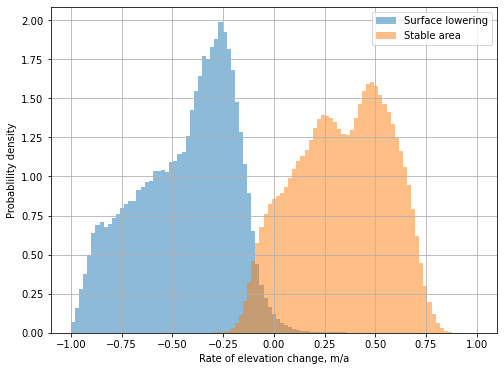

In [59]:
plt.figure(figsize=(8,6))
labels=[ 'Surface lowering','Stable area']

for i,k in enumerate([ 'diff_masked_to_bullseye','diff_masked_to_handrawn']):
    n, bins, patches = plt.hist(-stable_diff[k][~np.isnan(stable_diff[k])], 
                                  bins=np.linspace(-1,1,100), 
                                  density=True,alpha=0.5,
#                                 color=color[i],
                                label=labels[i]
                               )

#     plt.vlines(np.mean(stable_diff[i]),0,1.7,color='black')
#     plt.vlines(np.mean(stable_diff[i])-np.std(stable_diff[i]),0,1.7,color='red')
#     plt.vlines(np.mean(stable_diff[i])+np.std(stable_diff[i]),0,1.7,color='red')

# n, bins, patches = plt.hist(im[im>-10], 
#                               bins=np.linspace(-5,5,100), 
#                               density=True,alpha=0.5,
# #                                 color=color[i],
#                             label='Full difference image'
#                            )
plt.legend()
plt.xlabel("Rate of elevation change, m/a")
plt.ylabel("Probablility density")
plt.grid()
# plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/histograms_REMA.png')


In [70]:
k = 'diff_masked_to_bullseye'
be = -stable_diff[k][np.abs(stable_diff[k])<10]
k = 'diff_masked_to_handrawn'
sa = -stable_diff[k][np.abs(stable_diff[k])<10]

In [65]:
np.nanmean(be)

-0.43804476

In [67]:
np.nanstd(be)

0.23770823

In [71]:
np.nanmean(sa)

0.33738604

In [72]:
np.nanstd(sa)

0.25793973

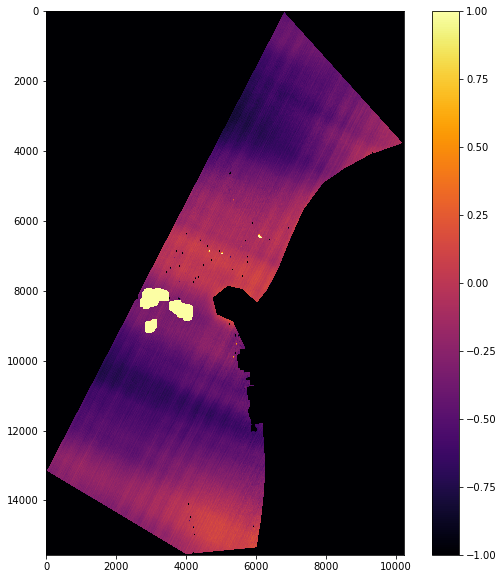

In [73]:
plt.figure(figsize=(10,10))
plt.imshow(stable_diff['diff_masked_to_handrawn'],
           vmin =-1,vmax=1,
           cmap='inferno')
plt.colorbar()
plt.show()

In [ ]:
# plt.figure(figsize=(10,10))
# plt.imshow(stable_diff['diff_masked_to_handrawn'],vmin =-1,vmax=0)
# plt.show()

In [55]:
k='diff_masked_to_handrawn'
2*np.std(stable_diff[k][~np.isnan(stable_diff[k])])

2537.827392578125

In [56]:
np.mean(stable_diff[k][~np.isnan(stable_diff[k])])

-1618.0603

In [57]:
np.std(stable_diff[k][~np.isnan(stable_diff[k])])

1268.9137

In [58]:
for k in ['diff_masked_to_bullseye', 'diff_masked_to_handrawn']:
    print(k)
    print(np.mean(stable_diff[k][~np.isnan(stable_diff[k])])+np.std(stable_diff[k][~np.isnan(stable_diff[k])]),
      np.mean(stable_diff[k][~np.isnan(stable_diff[k])])-np.std(stable_diff[k][~np.isnan(stable_diff[k])]))
    

diff_masked_to_bullseye
404.64893 -1965.7788
diff_masked_to_handrawn
-349.1466 -2886.974


In [55]:
for k in ['diff_masked_to_bullseye', 'diff_masked_to_handrawn']:
    print(k)
    print(np.mean(stable_diff[k][~np.isnan(stable_diff[k])]),
      np.std(stable_diff[k][~np.isnan(stable_diff[k])]))

diff_masked_to_bullseye
-780.56494 1185.2139
diff_masked_to_handrawn
-1618.0603 1268.9137


In [56]:
# #diff, not rate

# duration = (pd.to_datetime(t)-pd.to_datetime(f)).days/365.25
# with rio.open(path) as image:
#     ima = image.read(1)
# #     im[im==-9999] = np.nan
#     extent_REMAdiffa = [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
#     left = image.bounds[0]
#     bottom = image.bounds[1]
#     right = image.bounds[2]    
#     top = image.bounds[3]
    

In [57]:
# plt.imshow(ima,vmin=-5,vmax=10)
# plt.colorbar()

In [58]:
#checking lowering value


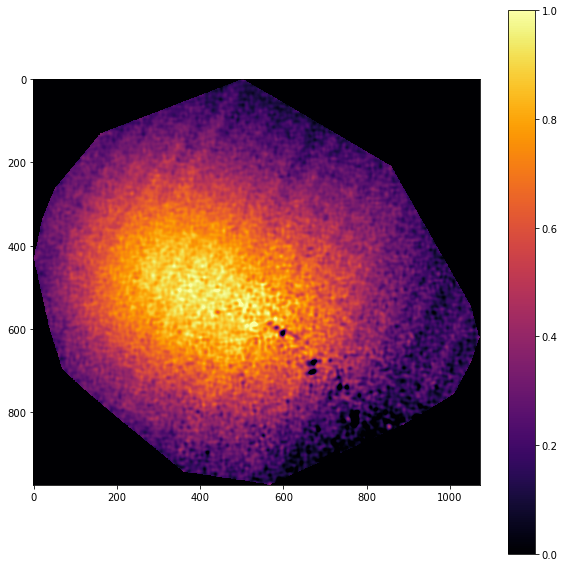

In [59]:
plt.figure(figsize=(10,10))
plt.imshow(stable_diff['diff_masked_to_bullseye'],vmin =0,vmax=1,cmap='inferno')
plt.colorbar()
plt.show()

In [60]:
stable_diff['diff_masked_to_bullseye'][stable_diff['diff_masked_to_bullseye']>0.95].shape

(5805,)

In [61]:
extent_REMAdiff

[-405458.0, -365488.0, -739742.0, -699564.0]

# Plots 

In [85]:
gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/STABLE/handdrawn_stablemask_3031.shp')
# gdf.crs

MemoryError: Unable to allocate 1.50 GiB for an array with shape (20089, 19985) and data type float32

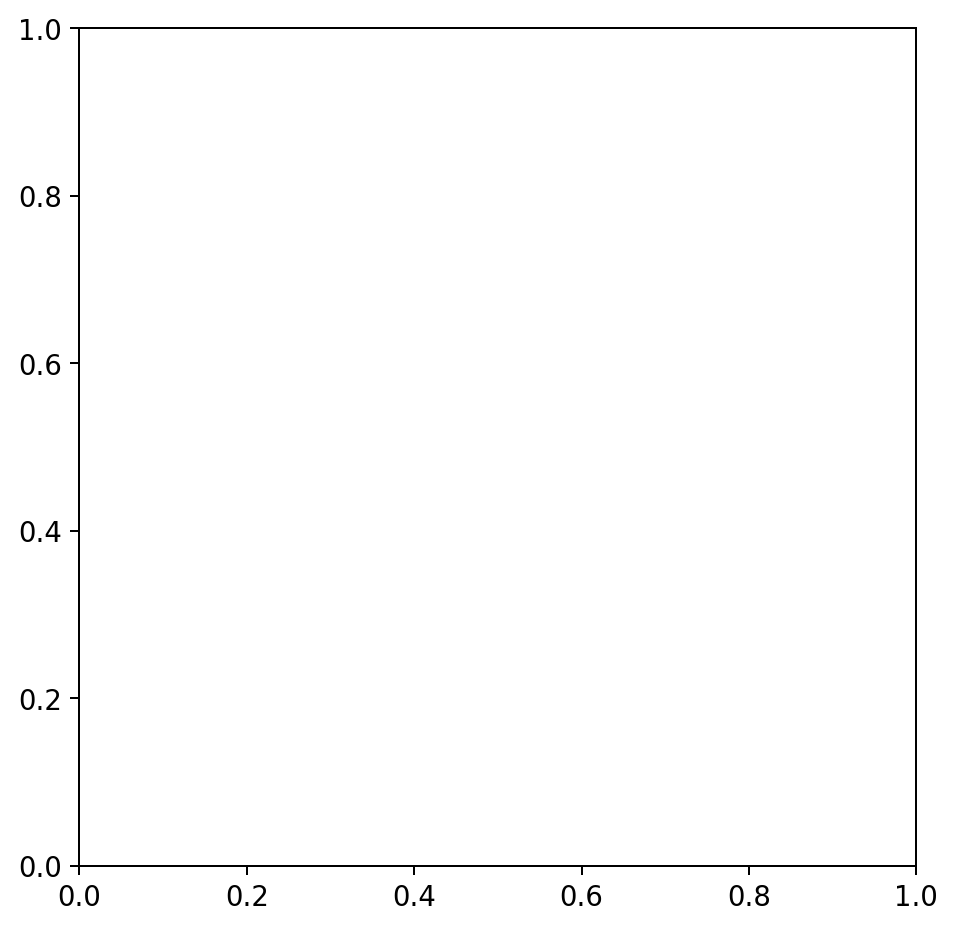

In [86]:
plt.figure( dpi=180,figsize=(6,8))

plt.rcParams.update({'font.size': 11})


plt.imshow(-im,extent=np.array(extent_REMAdiff),cmap='bwr_r',vmin=-1,vmax=1)
cb3 = plt.colorbar()
cb3.set_label('Rate of elevation change, m/a')
# cb3.set_ticks(np.round(np.linspace(-350+geoid_correction + res_correction,-700+geoid_correction + res_correction,5)/5)*5)

plt.plot(bullseye.exterior.xy[0],bullseye.exterior.xy[1],label='Surface lowering')
plt.plot(gdf.geometry.exterior[0].xy[0],gdf.geometry.exterior[0].xy[1],label='Stable area')


plt.xlim([-393000,extent_REMAdiff[1]])
plt.ylim([extent_REMAdiff[2],-707000])
plt.legend()
plt.savefig('/Users/home/whitefar/ASSIGNMENTS-PUBLICATIONS-TALKS/channel_data_writeup/PLOTS/REMA_diff_broad.png')


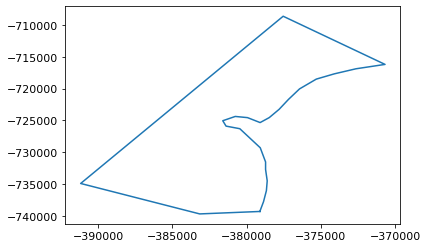

In [66]:
plt.plot(gdf.geometry.exterior[0].xy[0],gdf.geometry.exterior[0].xy[1])

In [67]:
bullseye.exterior.xy[0]

array('d', [-380242.7382906325, -380660.7592073659, -380952.77381905523, -381110.7817253803, -381238.7881305044, -381240.78823058447, -381302.7913330665, -381378.7951361089, -381378.7951361089, -381336.79303442757, -381276.7900320256, -381060.7792233787, -381058.77912329865, -381056.77902321855, -380372.7447958367, -380368.74459567654, -379656.70896717376, -379272.68975180143, -379232.68775020016, -379272.68975180143, -379354.6938550841, -379592.7057646117, -380236.7379903923, -380242.7382906325])